# SECTION 1 - Image Analysis

In [2]:
import os
import shutil
from zipfile import ZipFile
import cv2
import numpy as np
import re

# Paths
zip_path = "C:\\Users\\ynkpr\\Downloads\\US_Pictures.zip"
extract_dir = "C:\\Users\\ynkpr\\Downloads\\US_Pictures_FINAL"
output_dir = os.path.join(extract_dir, "Filtered_Images")

# Extract ZIP
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.makedirs(output_dir, exist_ok=True)

# 🔍 Detect software-drawn marker overlays
def has_marker(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    img_resized = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # 1. Identify scan region (bright background)
    _, scan_mask = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)

    # 2. Extract colored pixels: not grayscale (i.e., R ≠ G ≠ B)
    b, g, r = cv2.split(img_resized)
    color_mask = (
        (np.abs(r - g) > 15) |
        (np.abs(r - b) > 15) |
        (np.abs(g - b) > 15)
    ).astype(np.uint8) * 255

    # 3. Focus only on colored overlays on top of scan
    overlap = cv2.bitwise_and(color_mask, scan_mask)

    if np.count_nonzero(overlap) > 150:
        return True
    return False

# 📁 Collect all image paths
all_images = []
for root, _, files in os.walk(extract_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            all_images.append(os.path.join(root, file))

# 🧠 Group by ID like "1.1"
grouped = {}
for img_path in all_images:
    filename = os.path.basename(img_path)
    match = re.match(r'^(\d+\.\d+)', filename)
    if match:
        image_id = match.group(1)
        grouped.setdefault(image_id, []).append(img_path)

# ✂️ Detect and save
log = []
for image_id, paths in grouped.items():
    marker_img = None
    no_marker_img = None

    for path in paths:
        is_marker = has_marker(path)
        if is_marker is None:
            continue
        if is_marker and marker_img is None:
            marker_img = path
        elif not is_marker and no_marker_img is None:
            no_marker_img = path

    if marker_img:
        ext = os.path.splitext(marker_img)[1]
        shutil.copy(marker_img, os.path.join(output_dir, f"{image_id}_image_with_marker{ext}"))
        log.append(f"{image_id} ✅ marker")
    if no_marker_img:
        ext = os.path.splitext(no_marker_img)[1]
        shutil.copy(no_marker_img, os.path.join(output_dir, f"{image_id}_image_without_marker{ext}"))
        log.append(f"{image_id} ❌ no marker")

# ✅ Done
print(f"✅ Done. Filtered images saved in: {output_dir}")
print("\nSample log:")
for line in log[:10]:
    print("-", line)


✅ Done. Filtered images saved in: C:\Users\ynkpr\Downloads\US_Pictures_FINAL\Filtered_Images

Sample log:
- 1.1 ✅ marker
- 1.2 ✅ marker
- 1.3 ✅ marker
- 1.4 ✅ marker
- 1.5 ✅ marker
- 10.1 ✅ marker
- 10.2 ✅ marker
- 100.1 ✅ marker
- 100.2 ✅ marker
- 100.3 ✅ marker


C:\Users\ynkpr\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


🔧 Training Model A...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
🔧 Training Model B...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
🔧 Training Model C...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
🔧 Training Model D...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
     Model      Dice  Accuracy  Sensitivity  Specificity  Precision       TP  \
0  Model A  0.961156  0.963895     0.972076     0.956939   0.950478  3059182   
1  Model B  0.962881  0.965890     0.962760     0.968551   0.963002  3029862   
2  Model C  0.960886  0.964194     0.957117     0.970210   0.964685  3012106   
3  Model D  0.957507  0.961488     0.944228     0.976163   0.971164  2971541   

       FP      FN       TN  
0  159390   87878  3542062  
1  116406  117198  3585046  
2  110266  134954  3591186  
3   88231  175519  3613221  


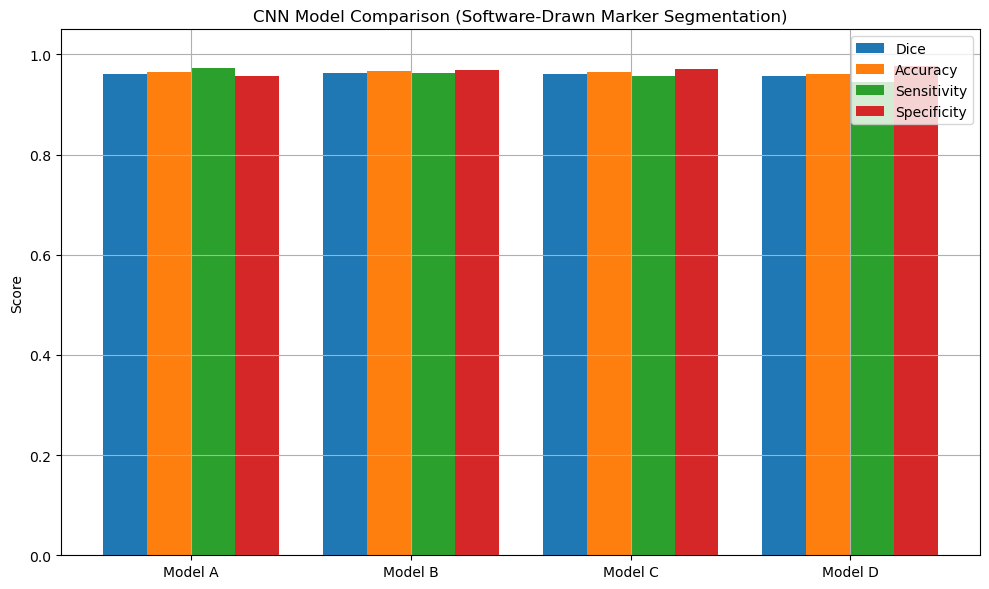

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Updated preprocessing for software-drawn overlay markers
def preprocess_image(img_path, image_size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None: return None, None

    # Resize image
    img_resized = cv2.resize(img, image_size)
    
    # Convert to grayscale for model input
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) / 255.0
    input_img = np.expand_dims(gray, -1)

    # Marker segmentation: detect non-grayscale pixels (R ≠ G ≠ B)
    b, g, r = cv2.split(img_resized)
    color_mask = ((np.abs(r - g) > 15) | (np.abs(r - b) > 15) | (np.abs(g - b) > 15)).astype(np.uint8) * 255

    # Morphological operations
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    mask_resized = cv2.resize(color_mask, image_size)
    output_mask = np.expand_dims((mask_resized > 0).astype(np.float32), -1)

    return input_img, output_mask

# 2. Load dataset
folder = "C:/Users/ynkpr/Downloads/US_Pictures_FINAL/Filtered_Images"
files = [f for f in os.listdir(folder) if "image_with_marker" in f.lower()]
X, Y = [], []
for f in files:
    x, y = preprocess_image(os.path.join(folder, f))
    if x is not None:
        X.append(x)
        Y.append(y)

X = np.array(X)
Y = np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Model architecture generator
def build_cnn(filters):
    inputs = layers.Input((128, 128, 1))
    x = inputs
    for f in filters:
        x = layers.Conv2D(f, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D()(x)
    for f in reversed(filters):
        x = layers.Conv2D(f, 3, activation='relu', padding='same')(x)
        x = layers.UpSampling2D()(x)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

# 4. Evaluation metrics
def evaluate_model(model, X_test, Y_test):
    Y_pred = (model.predict(X_test) > 0.5).astype(np.uint8)
    y_true = Y_test.flatten()
    y_pred = Y_pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    dice = 2 * tp / (2 * tp + fp + fn + 1e-7)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp + 1e-7)
    precision = precision_score(y_true, y_pred, zero_division=0)
    return dice, accuracy, sensitivity, specificity, precision, tp, fp, fn, tn

# 5. Train multiple CNN models
configs = {
    "Model A": [16, 32],
    "Model B": [32, 64],
    "Model C": [16, 32, 64],
    "Model D": [8, 16, 32]
}
results = []

for name, filters in configs.items():
    print(f"🔧 Training {name}...")
    model = build_cnn(filters)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(X_train, Y_train, epochs=5, batch_size=8, verbose=0)
    metrics = evaluate_model(model, X_test, Y_test)
    results.append([name] + list(metrics))

# 6. Display and plot results
columns = ["Model", "Dice", "Accuracy", "Sensitivity", "Specificity", "Precision", "TP", "FP", "FN", "TN"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

# 7. Plot results
x = np.arange(len(results_df["Model"]))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.3, results_df["Dice"], width=0.2, label='Dice')
plt.bar(x - 0.1, results_df["Accuracy"], width=0.2, label='Accuracy')
plt.bar(x + 0.1, results_df["Sensitivity"], width=0.2, label='Sensitivity')
plt.bar(x + 0.3, results_df["Specificity"], width=0.2, label='Specificity')
plt.xticks(x, results_df["Model"])
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("CNN Model Comparison (Software-Drawn Marker Segmentation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## out of the 5 selected images for segmenation below, the buttom 2 shows better prediction than the top 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


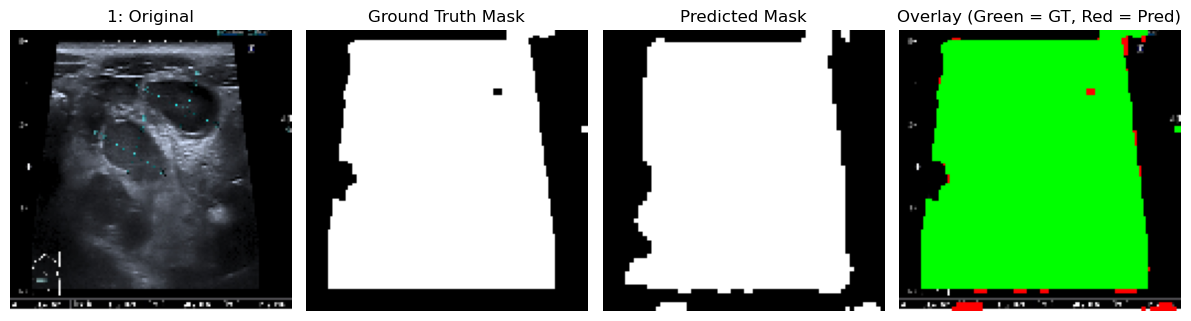

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


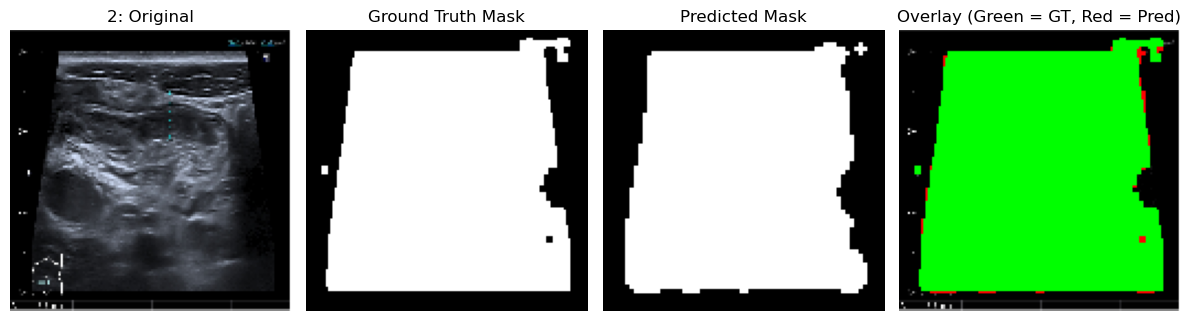

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


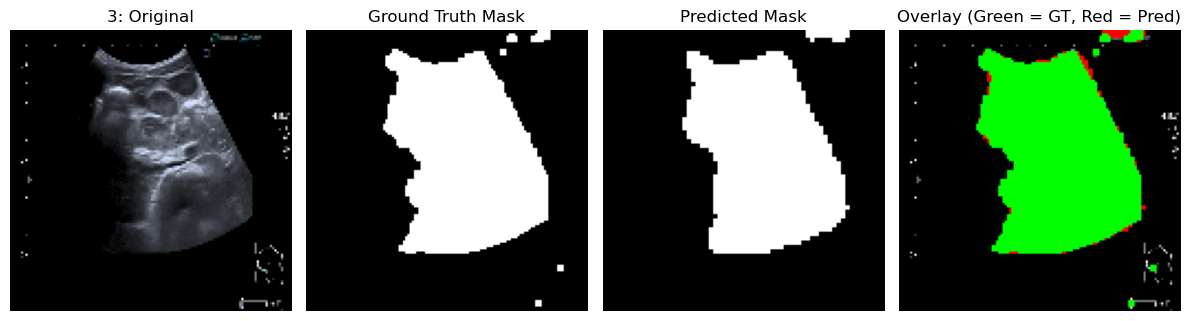

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


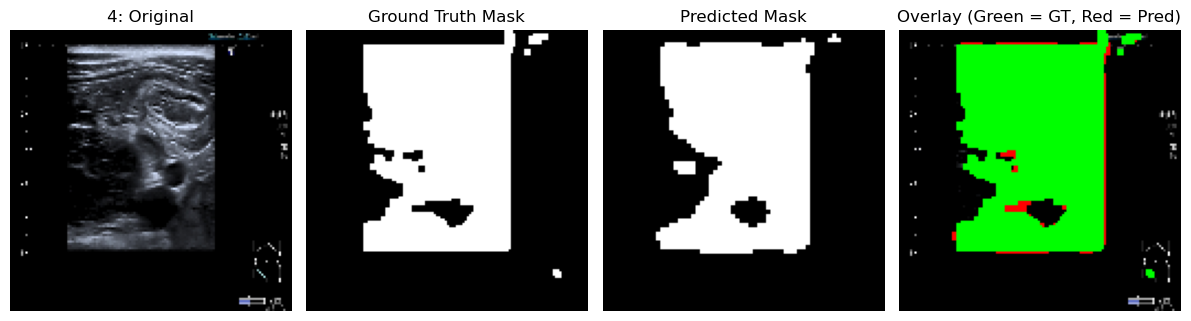

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


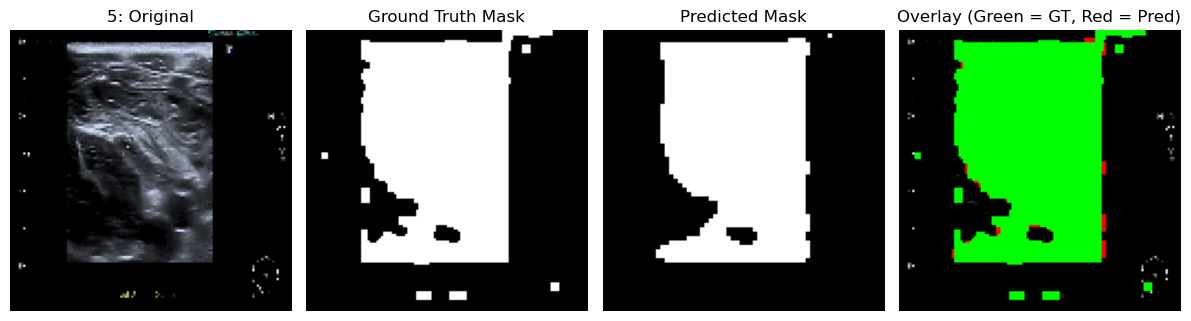

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# --- 1. Marker Segmentation Function ---
def segment_marker_mask(img_path, image_size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None, None

    img_resized = cv2.resize(img, image_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY) / 255.0
    input_img = np.expand_dims(gray, -1)

    b, g, r = cv2.split(img_resized)
    mask = ((np.abs(r - g) > 15) | (np.abs(r - b) > 15) | (np.abs(g - b) > 15)).astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    output_mask = np.expand_dims((mask > 0).astype(np.float32), -1)

    return input_img, output_mask, cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# --- 2. Path to All Marker Images ---
folder = "C:/Users/ynkpr/Downloads/US_Pictures_FINAL/Filtered_Images"
image_files = [f for f in os.listdir(folder) if "image_with_marker" in f.lower()]
image_paths = [os.path.join(folder, f) for f in image_files]

# --- 3. Loop Through All Images and Predict ---
for i, path in enumerate(image_paths[:5]):  # Adjust [:5] to more if needed
    X_img, Y_true_mask, original_rgb = segment_marker_mask(path)

    if X_img is None or Y_true_mask is None or original_rgb is None:
        print(f"❌ Could not process: {os.path.basename(path)}")
        continue

    X_input = np.expand_dims(X_img, 0).astype(np.float32)
    Y_pred_mask = model.predict(X_input)[0].squeeze()
    Y_pred_bin = (Y_pred_mask > 0.5).astype(np.uint8)

    # --- 4. Visualize ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title(f"{i+1}: Original")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(Y_true_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(Y_pred_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Overlay
    overlay = original_rgb.copy()
    overlay[Y_pred_bin > 0] = [255, 0, 0]  # Red = Predicted
    overlay[Y_true_mask.squeeze() > 0.5] = [0, 255, 0]  # Green = GT

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay (Green = GT, Red = Pred)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# SECTION 2 Tabular data analysis

# Exploratory Analysis

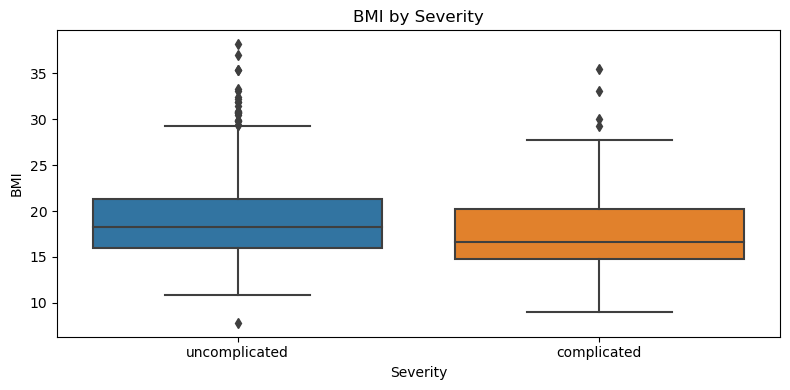

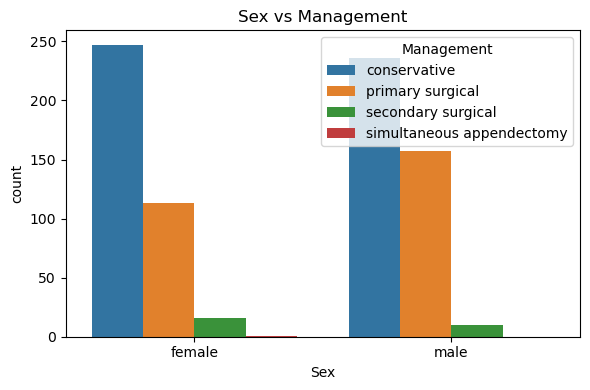

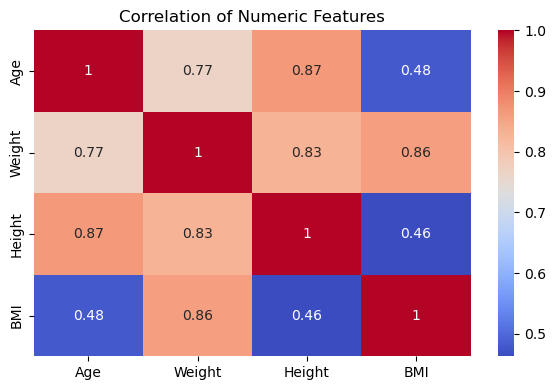

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


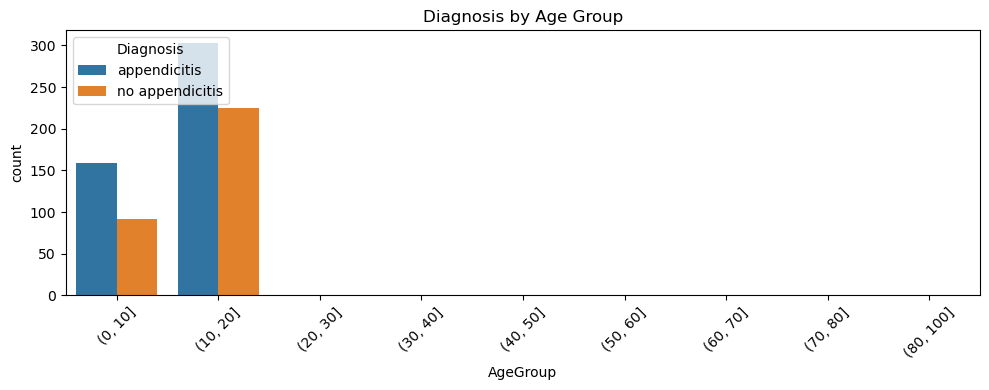

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Load and Clean Dataset ---
df = pd.read_excel("C:\\Users\\ynkpr\\Downloads\\app_data (1).xlsx")
df.columns = df.columns.str.strip()  # Clean column names
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Convert numeric fields
for col in ['Age', 'Weight', 'Height', 'BMI']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 2. Exploratory Analysis on Age, Sex, Weight, Height, BMI ---


# Plot 1: BMI vs Severity
plt.figure(figsize=(8,4))
sns.boxplot(x='Severity', y='BMI', data=df)
plt.title("BMI by Severity")
plt.tight_layout()
plt.show()

# Plot 2: Sex vs Management
plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='Management', data=df)
plt.title("Sex vs Management")
plt.tight_layout()
plt.show()



# Plot 3: Correlation matrix
numeric_cols = ['Age', 'Weight', 'Height', 'BMI']
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Numeric Features")
plt.tight_layout()
plt.show()


# Plot 4: Age group vs Diagnosis
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,10,20,30,40,50,60,70,80,100])
plt.figure(figsize=(10,4))
sns.countplot(x='AgeGroup', hue='Diagnosis', data=df)
plt.title("Diagnosis by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Data Preprocessing , Models and Results

In [19]:
# --- 3. Data Preprocessing ---
# Drop rows missing any target
df.dropna(subset=['Management', 'Severity', 'Diagnosis'], inplace=True)

# Encode all categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna("Unknown")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert remaining numeric columns and impute missing values
for col in df.columns:
    if df[col].dtype != 'object' and df[col].isnull().sum() > 0:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].mean(), inplace=True)

# Drop helper column if exists
if 'AgeGroup' in df.columns:
    df.drop(columns='AgeGroup', inplace=True)

# --- 4. Model Evaluation Function ---
def evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB()
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": report['weighted avg']['precision'],
            "Recall": report['weighted avg']['recall'],
            "F1-Score": report['weighted avg']['f1-score']
        })

    return pd.DataFrame(results)

# --- 5. Define Features and Targets ---
target_vars = ['Management', 'Severity', 'Diagnosis']
feature_vars = [col for col in df.columns if col not in target_vars]

# --- 6. Run Evaluations ---
results_mgmt = evaluate_models(df[feature_vars], df['Management'])
results_sev = evaluate_models(df[feature_vars], df['Severity'])
results_dx = evaluate_models(df[feature_vars], df['Diagnosis'])

# --- 7. Show Results ---
print("\n--- Management Model Results ---")
print(results_mgmt)

print("\n--- Severity Model Results ---")
print(results_sev)

print("\n--- Diagnosis Model Results ---")
print(results_dx)


C:\Users\ynkpr\AppData\Local\Temp\ipykernel_34876\2590127829.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\ynkpr\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ynkpr\AppData\Roaming\Python\Python311


--- Management Model Results ---
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.880342   0.881590  0.880342  0.880322
1        Random Forest  0.940171   0.941549  0.940171  0.930773
2        Decision Tree  0.897436   0.896915  0.897436  0.896727
3          Naive Bayes  0.811966   0.902849  0.811966  0.844482

--- Severity Model Results ---
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.914530   0.914530  0.914530  0.914530
1        Random Forest  0.931624   0.928733  0.931624  0.929026
2        Decision Tree  0.901709   0.902857  0.901709  0.902258
3          Naive Bayes  0.871795   0.871795  0.871795  0.871795

--- Diagnosis Model Results ---
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.867521   0.874467  0.867521  0.868317
1        Random Forest  0.910256   0.910159  0.910256  0.910191
2        Decision Tree  0.893162   0.892969  0.893162  0.892915
3    

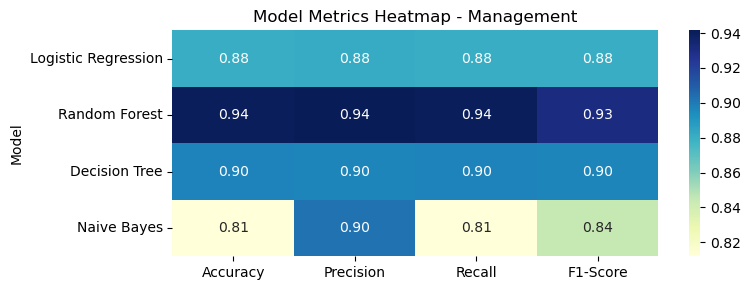

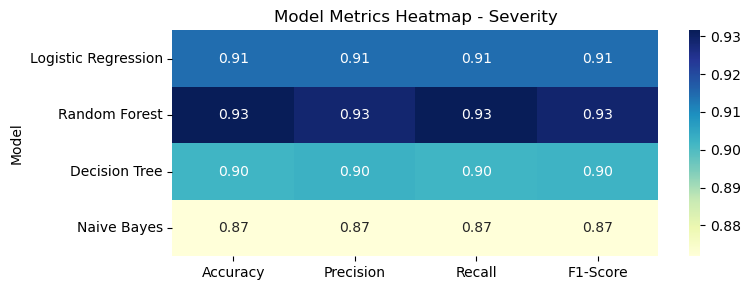

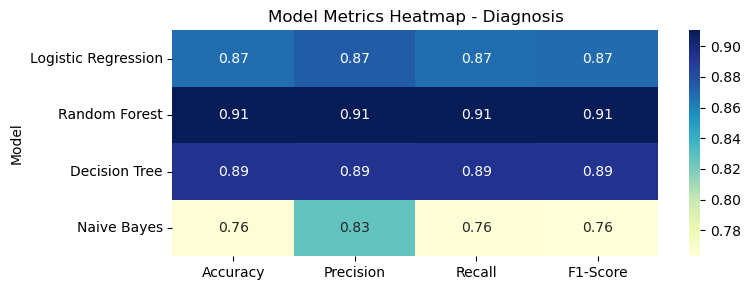

In [20]:
def plot_heatmap(df, title):
    plt.figure(figsize=(8, 3))
    data = df.set_index('Model').astype(float)
    sns.heatmap(data, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(results_mgmt, "Model Metrics Heatmap - Management")
plot_heatmap(results_sev, "Model Metrics Heatmap - Severity")
plot_heatmap(results_dx, "Model Metrics Heatmap - Diagnosis")
